In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from random import sample


In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 
idx = pd.IndexSlice

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=MEDIUM_SIZE) 
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  #
#plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
#plt.rcParams["fig.titleweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.title_fontsize"] = 20
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
#Optionally set font to Computer Modern to avoid common missing font errors
#plt.rc('font', family='serif', serif='cm10')

#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble'] = [r'\boldmath']


In [3]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)


## Load data and visualize distribution


In [4]:
#select simulation
impflist = ['Cubic excess-over-threshold', 'Emanuel 2011', 'Schwierz 2010']
impf_shtlist = [impf_sht_names[impf] for impf in impflist]
pp_func_dic = pp_func_dic_diff
caltype = 'AAI_EMDAT_100mn'
metrics = np.arange(1,31).tolist()
#metrics = np.append(metrics,[20,30])
modlist = modlist_allscen
periods = ["past","future"]

In [5]:
#load impact data into a dataframe
nmems = 3
nscens = len(scenlist)
nmets = len(metrics)
#initiate df
nmem_idx = range(nmems)
col_idx = pd.MultiIndex.from_product([metrics,scenlist], names=["metric","scenario"])
row_idx = pd.MultiIndex.from_product([modlist,nmem_idx,impf_shtlist],names=["model","member","impf"])
res_list = []


stoc_df = pd.DataFrame(columns=col_idx,index=row_idx)
stoc_df.sort_index(inplace=True)
stoc_df.sort_index(inplace=True,axis=1)
for modname in modlist:
    for scen in scenlist:
        for imem in range(nmems):
            for impf in impflist:
                comp_metrics = metrics.copy()
                impf_namesht = impf_sht_names[impf]
                #get pp_func
                pp_funcname = str(pp_func_dic[impf]).split(" ")[1]
                #make file names
                impfn= make_fn(['imp','nmem'+str(imem),scen,modname,impf_namesht,caltype,pp_funcname],basenamemet_proc,filetype='.csv')
                imp = Impact()
                imp = imp.from_csv(pathimp+"impact csv/aggregated/memsep/"+scen+"/"+impfn)        
                if 'aai_agg' in metrics:
                    stoc_df.loc[(modname,imem,impf_namesht),('aai_agg',scen)] = imp.aai_agg
                    comp_metrics.remove('aai_agg')
                stoc_df.loc[idx[modname,imem,impf_namesht],idx[comp_metrics,scen]] = imp.calc_freq_curve(return_per=comp_metrics).impact
                #stoc_df.loc[(modname,imem,impf_namesht),(comp_metrics,period,scen)] = imp.calc_freq_curve(return_per=comp_metrics).impact
    
stoc_df = stoc_df.astype(np.float64)
#res_list.append(stoc_df)
#res_df2 = pd.concat(res_list,keys=metrics,axis=1)
res_df2 = stoc_df

In [6]:
res_df2

metric                                 1                               \
scenario                       historical        ssp126        ssp245   
model         member impf                                               
ACCESS-ESM1-5 0      CubEOT  7.374478e+08  5.452763e+08  6.646104e+08   
                     Em2011  5.661040e+08  6.223881e+08  6.811828e+08   
                     Sw2010  6.088832e+08  5.942799e+08  7.475073e+08   
              1      CubEOT  6.275458e+08  8.788322e+08  5.100658e+08   
                     Em2011  5.953515e+08  6.973143e+08  5.715997e+08   
...                                   ...           ...           ...   
UKESM1-0-LL   1      Em2011  6.087779e+08  2.953450e+08  3.449525e+08   
                     Sw2010  6.672212e+08  3.044007e+08  3.694264e+08   
              2      CubEOT  7.988241e+08  3.673774e+08  3.721058e+08   
                     Em2011  7.705408e+08  3.143405e+08  3.675990e+08   
                     Sw2010  8.360691e+08  3.227271e+08  3.593014e+08   

metric                                                             2   \
scenario                           ssp370        ssp585    historical   
model         member impf                                               
ACCESS-ESM1-5 0      CubEOT  6.964900e+08  6.991806e+08  1.239394e+09   
                     Em2011  6.166142e+08  8.273416e+08  8.464523e+08   
                     Sw2010  6.783678e+08  1.033552e+09  9.501201e+08   
              1      CubEOT  8.342563e+08  6.516177e+08  1.129302e+09   
                     Em2011  8.636953e+08  7.017967e+08  7.614970e+08   
...                                   ...           ...           ...   
UKESM1-0-LL   1      Em2011  2.896474e+08  3.397345e+08  9.016579e+08   
                     Sw2010  2.945839e+08  3.407293e+08  8.579429e+08   
              2      CubEOT  3.308260e+08  5.453610e+08  1.177787e+09   
                     Em2011  3.221300e+08  3.838005e+08  1.230667e+09   
                     Sw2010  3.796583e+08  3.809901e+08  1.997373e+09   

metric                                                                 \
scenario                           ssp126        ssp245        ssp370   
model         member impf                                               
ACCESS-ESM1-5 0      CubEOT  1.180536e+09  1.304281e+09  1.342786e+09   
                     Em2011  1.004285e+09  1.188421e+09  9.550623e+08   
                     Sw2010  1.388274e+09  1.373344e+09  1.378259e+09   
              1      CubEOT  1.409846e+09  9.419192e+08  1.430081e+09   
                     Em2011  1.013504e+09  7.765123e+08  1.337850e+09   
...                                   ...           ...           ...   
UKESM1-0-LL   1      Em2011  5.102196e+08  4.970498e+08  3.964753e+08   
                     Sw2010  6.429403e+08  5.260716e+08  4.346268e+08   
              2      CubEOT  5.790194e+08  5.765217e+08  5.489436e+08   
                     Em2011  4.461455e+08  5.259966e+08  6.109922e+08   
                     Sw2010  5.562328e+08  7.092515e+08  6.468375e+08   

metric                                     ...            29                \
scenario                           ssp585  ...    historical        ssp126   
model         member impf                  ...                               
ACCESS-ESM1-5 0      CubEOT  1.120517e+09  ...  1.842079e+10  6.113261e+09   
                     Em2011  1.091865e+09  ...  7.852915e+09  3.996871e+09   
                     Sw2010  1.438728e+09  ...  1.777183e+10  9.003042e+09   
              1      CubEOT  1.174720e+09  ...  5.973655e+09  9.192153e+09   
                     Em2011  9.771898e+08  ...  3.592994e+09  3.731085e+09   
...                                   ...  ...           ...           ...   
UKESM1-0-LL   1      Em2011  5.495451e+08  ...  5.946639e+09  2.089478e+09   
                     Sw2010  6.953836e+08  ...  1.099143e+10  7.754712e+09   
              2      CubEOT  9.158776e+08  ...  5.443089e+09  2.244619e+0

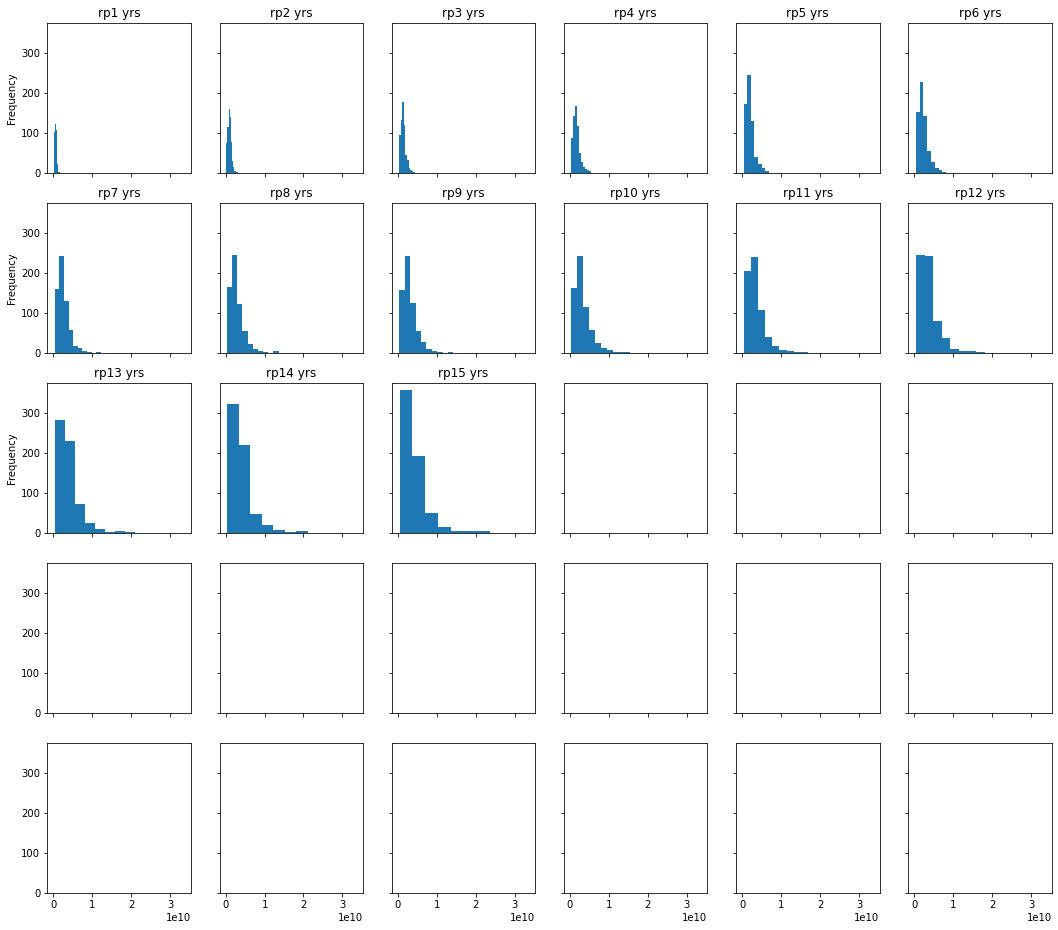

In [8]:
##stacking SSPs
#stacked_all = pd.DataFrame(diff_df_ss.stack(level="region")).reset_index()
res_df_stacked = res_df2.stack(level="scenario").reset_index()

##plot
#initiate fig
nmets =15
fig = plt.figure(figsize=(18,16))
axs = fig.subplots(nrows=5,ncols=6,sharey=True,sharex=True).flatten()
for imet in range(nmets):
    ax = axs[imet]
    res_ss = res_df_stacked[imet+1]
    res_ss.plot.hist(ax=ax)
    ax.set_title("rp"+str(imet+1)+" yrs")
    #ax.set_xlabel("impact (USD)")
        

## ANOVA future

In [6]:
## ANOVA future without bootstrapping
#unc_idx = ['Stochastic',"Scenario","Model","Impact function",'Model-scenario interaction','Model-imp. func. interaction']


norm_exc = False
norm_tot = True
ms_interaction = True
mi_interaction = True
add_tot_unc = False
unc_idx = ['Stochastic',"Scenario","Model","Impact function"]
if ms_interaction:
    unc_idx.append('Model-scenario interaction')
    
if mi_interaction:
    unc_idx.append('Model-impf. interaction')


unc_df_fut = pd.DataFrame(columns=metrics,index=unc_idx)
for metric in metrics:
    df = res_df2[metric].copy().drop("historical",axis=1)
    mod_mean = df.groupby(level="model").mean().mean(axis=1)
    impf_mean = df.groupby(level="impf").mean().mean(axis=1)
    scen_mean = df.mean()
    mod_scen_mean = df.groupby(level="model").mean()
    mod_impf_mean = df.groupby(level=["model","impf"]).mean().mean(axis=1)
    mod_scen_impf_mean = df.groupby(level=["model","impf"]).mean()
    nscen = len(scen_mean)
    nreal = nmems
    nmod = len(mod_mean)
    nimpf = len(impf_mean)
    ens_mean = df.mean().mean()
    #internal variabilty    
    intvar = 1/(nscen*nreal*nmod*nimpf)*np.sum(np.sum(np.sum((df.sub(mod_scen_impf_mean,axis=0))**2)))
    
    #scenario-inde model uncertainty
    mod_ind_var = 1/nmod*np.sum((mod_mean-ens_mean)**2)
    
    #scenario uncertainty
    scen_var = 1/nscen*np.sum((scen_mean-ens_mean)**2)
    
    #model-scenario interaction uncertainty
    modscen_int = 1/(nscen*nmod)*np.sum(np.sum((mod_scen_mean.add(ens_mean).sub(mod_mean,axis=0).sub(scen_mean,axis=1))**2))
    
    #impf uncertainty
    impf_ind_var = 1/nimpf*np.sum((impf_mean-ens_mean)**2)
    
    #model-impf interaction uncertainty
    modimpf_int = 1/(nmod*nimpf)*np.sum(np.sum((mod_impf_mean.add(ens_mean).sub(mod_mean,axis=0).sub(impf_mean,axis=0))**2))
    
    unc_df_fut.loc['Stochastic',metric] = intvar
    unc_df_fut.loc['Model',metric] = mod_ind_var
    unc_df_fut.loc['Scenario',metric] = scen_var
    unc_df_fut.loc["Impact function",metric] = impf_ind_var
    
    #tot uncertainty
    exp_unc = intvar + mod_ind_var + scen_var + impf_ind_var
    if ms_interaction:
        exp_unc = exp_unc + modscen_int 
        unc_df_fut.loc['Model-scenario interaction',metric] = modscen_int
    if mi_interaction:
        exp_unc = exp_unc + modimpf_int
        unc_df_fut.loc['Model-impf. interaction',metric] = modimpf_int
    
    # or tot uncertainty
    tot_unc = np.sum(np.sum((df-ens_mean)**2))/(nscen*nreal*nmod*nimpf)
    print("Explained variance (%):"+format(100*exp_unc/tot_unc,'.3'))

    if norm_exc:
        unc_df_fut[metric] = (100/exp_unc)*unc_df_fut[metric]
    if norm_tot:
        unc_df_fut[metric] = (100/tot_unc)*unc_df_fut[metric]
    if add_tot_unc:
        unc_df_fut.loc['Total uncertainty [log10(USD)]',metric] = np.log10(tot_unc)
        
unc_df_fut = unc_df_fut.astype(np.float64)

Explained variance (%):98.8
Explained variance (%):98.0
Explained variance (%):96.6
Explained variance (%):96.5
Explained variance (%):95.6
Explained variance (%):94.5
Explained variance (%):94.8
Explained variance (%):95.3
Explained variance (%):96.0
Explained variance (%):96.3
Explained variance (%):96.2
Explained variance (%):95.8
Explained variance (%):95.4
Explained variance (%):94.9
Explained variance (%):94.5
Explained variance (%):94.2
Explained variance (%):94.0
Explained variance (%):93.8
Explained variance (%):93.6
Explained variance (%):93.3
Explained variance (%):93.1
Explained variance (%):92.9
Explained variance (%):92.7
Explained variance (%):92.6
Explained variance (%):92.4
Explained variance (%):92.3
Explained variance (%):92.1
Explained variance (%):92.0
Explained variance (%):91.9
Explained variance (%):91.8


In [61]:
## ANOVA future using bootstrapping

#ANOVA model 
norm_exc = False #normalize uncertainty by the explained uncertainty of the model
norm_tot = False #normalize uncertainty by the total uncertainy (i.e. total uncertainty including higher-order interaction terms)
ms_interaction = True #add model-scenario interaction term
mi_interaction = True #add model-impact function interaction term
add_tot_unc = False #add total uncetainty to the dataframe

unc_idx = ['Stochastic',"Scenario","Model","Impact function"]
if ms_interaction:
    unc_idx.append('Model-scenario interaction')
    
if mi_interaction:
    unc_idx.append('Model-impf. interaction')

#bootstrapping
nreps = 1000  
modlist = modlist_allscen
selscen = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
sub_sample_size = 3 #factor variable with the minimum nb of levels: impf and members
nunc = len(unc_idx)
nmetrics = len(metrics)
resarr = np.nan * np.ones(shape=(nunc,nmetrics,nreps))
for rep in range(nreps):
    unc_df_fut = pd.DataFrame(columns=metrics,index=unc_idx)
    subsel_mod = sample(modlist, k=sub_sample_size)
    subsel_scen= sample(selscen, k=sub_sample_size)

    for metric in metrics:
        df = res_df2.loc[subsel_mod][metric][subsel_scen].copy()
        mod_mean = df.groupby(level="model").mean().mean(axis=1)
        impf_mean = df.groupby(level="impf").mean().mean(axis=1)
        scen_mean = df.mean()
        mod_scen_mean = df.groupby(level="model").mean()
        mod_impf_mean = df.groupby(level=["model","impf"]).mean().mean(axis=1)
        mod_scen_impf_mean = df.groupby(level=["model","impf"]).mean()
        nscen = len(scen_mean)
        nreal = nmems
        nmod = len(mod_mean)
        nimpf = len(impf_mean)
        ens_mean = df.mean().mean()
        #internal variabilty    
        intvar = 1/(nscen*nreal*nmod*nimpf)*np.sum(np.sum(np.sum((df.sub(mod_scen_impf_mean,axis=0))**2)))
        
        #scenario-inde model uncertainty
        mod_ind_var = 1/nmod*np.sum((mod_mean-ens_mean)**2)
        
        #scenario uncertainty
        scen_var = 1/nscen*np.sum((scen_mean-ens_mean)**2)
        
        #model-scenario interaction uncertainty
        modscen_int = 1/(nscen*nmod)*np.sum(np.sum((mod_scen_mean.add(ens_mean).sub(mod_mean,axis=0).sub(scen_mean,axis=1))**2))
        
        #impf uncertainty
        impf_ind_var = 1/nimpf*np.sum((impf_mean-ens_mean)**2)
        
        #model-impf interaction uncertainty
        modimpf_int = 1/(nmod*nimpf)*np.sum(np.sum((mod_impf_mean.add(ens_mean).sub(mod_mean,axis=0).sub(impf_mean,axis=0))**2))
        
        unc_df_fut.loc['Stochastic',metric] = intvar
        unc_df_fut.loc['Model',metric] = mod_ind_var
        unc_df_fut.loc['Scenario',metric] = scen_var
        unc_df_fut.loc["Impact function",metric] = impf_ind_var
        
        #tot uncertainty
        exp_unc = intvar + mod_ind_var + scen_var + impf_ind_var
        if ms_interaction:
            exp_unc = exp_unc + modscen_int 
            unc_df_fut.loc['Model-scenario interaction',metric] = modscen_int
        if mi_interaction:
            exp_unc = exp_unc + modimpf_int
            unc_df_fut.loc['Model-impf. interaction',metric] = modimpf_int
        
        # or tot uncertainty
        tot_unc = np.sum(np.sum((df-ens_mean)**2))/(nscen*nreal*nmod*nimpf)
        #print("Explained variance (%):"+format(100*exp_unc/tot_unc,'.3'))
    
        if norm_exc:
            unc_df_fut[metric] = (100/exp_unc)*unc_df_fut[metric]
        if norm_tot:
            unc_df_fut[metric] = (100/tot_unc)*unc_df_fut[metric]
        if add_tot_unc:
            unc_df_fut.loc['Total uncertainty [log10(USD)]',metric] = np.log10(tot_unc)
    unc_df_fut = unc_df_fut.astype(np.float64)
    resarr[:,:,rep] = unc_df_fut.values
unc_df_fut_all = pd.DataFrame(resarr.mean(axis=2),index=unc_idx,columns=metrics)

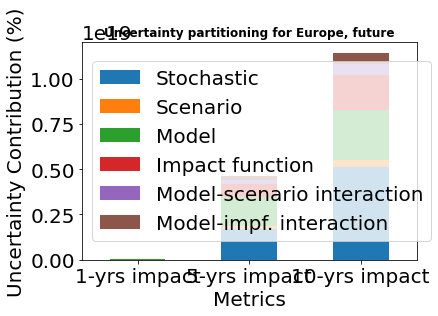

In [71]:
sel_met = [1,5,10]
unc_df_fut_ss = unc_df_fut_all.loc[unc_idx,[1,10,15]]
unc_df_fut_ss.columns = [str(metric)+'-yrs impact' for metric in sel_met]
ax = unc_df_fut_ss.T.plot.bar(stacked=True,rot=0)
ax.set_ylabel('Uncertainty Contribution (%)')
ax.set_xlabel('Metrics')
ax.set_title('Uncertainty partitioning for Europe, future')
plt.legend(loc='center left')
basenameimp = make_fn(['imp',caltype],basenamemet_proc)
#savename = 'unc_part_EU_fut_ms_mi_inter_rp1_rp10'+basenameimp+'.png'
#plt.savefig(pathfig+'/Uncertainty/'+savename,transparent=False)

In [130]:
def style_10high(v, props=''):
    return props if v > 10 else None
unc_df_fut_all.index.name = 'Uncertainty partitioning for Europe (%)'
s2 = unc_df_fut_all.style.applymap(style_10high, props='color:red;')
s2.format('{:.2f}')


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
Uncertainty partitioning for Europe (%),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Stochastic,26.00,27.64,26.86,28.87,30.27,31.02,33.50,35.57,36.84,38.82,38.98,40.00,41.34,42.72,44.02,43.27,42.94,42.87,42.96,43.14,43.37,43.63,43.91,44.19,44.48,44.76,45.04,45.31,45.58,45.83
Scenario,6.06,6.00,6.48,6.33,6.19,6.27,5.76,5.28,4.93,4.63,4.53,4.39,4.24,4.11,4.00,4.07,4.08,4.07,4.04,4.01,3.97,3.94,3.90,3.87,3.84,3.81,3.78,3.76,3.73,3.71
Model,54.12,52.48,48.66,44.13,40.28,36.24,32.80,30.44,29.19,27.35,26.29,24.77,23.17,21.67,20.33,19.69,19.00,18.31,17.66,17.04,16.48,15.95,15.47,15.02,14.61,14.24,13.89,13.56,13.26,12.98
Impact function,3.40,2.70,5.04,7.53,9.22,10.99,12.68,13.86,14.95,15.35,16.32,16.69,16.69,16.51,16.24,17.27,18.01,18.54,18.92,19.19,19.39,19.53,19.62,19.68,19.71,19.72,19.71,19.70,19.67,19.64
Model-scenario interaction,5.28,5.19,6.26,6.21,6.37,6.53,6.25,5.93,5.63,5.44,5.44,5.45,5.47,5.51,5.54,5.72,5.86,5.97,6.05,6.12,6.17,6.22,6.25,6.28,6.30,6.32,6.34,6.36,6.37,6.38
Model-impf. interaction,3.65,3.37,3.02,3.05,3.34,3.60,4.07,4.27,4.28,4.29,4.41,4.50,4.56,4.61,4.63,4.61,4.59,4.58,4.58,4.58,4.58,4.58,4.59,4.59,4.60,4.61,4.61,4.62,4.62,4.63


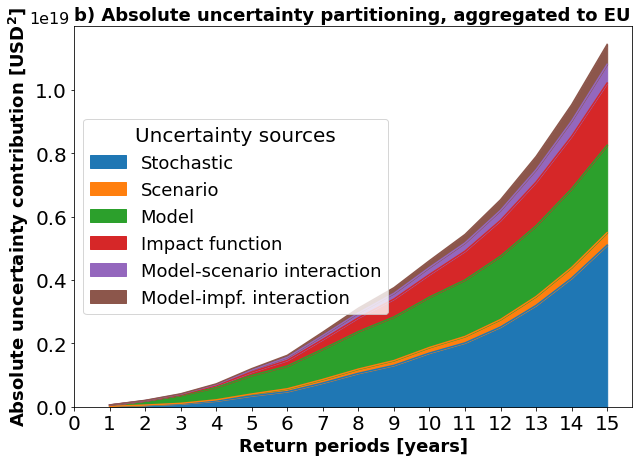

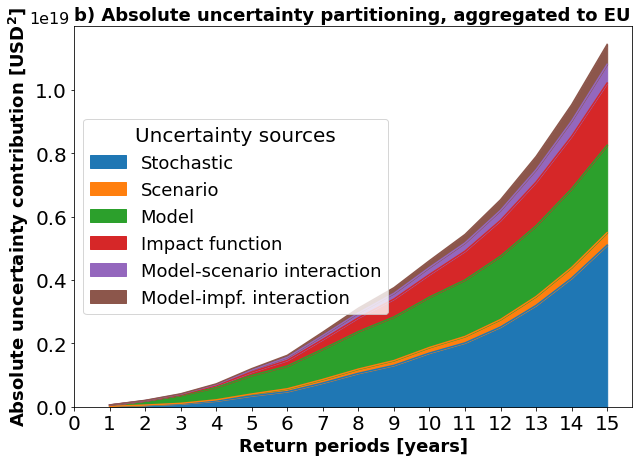

In [72]:
#unc vs rp plots
#select data
basenameimp = make_fn(['imp',caltype],basenamemet_proc)
unc_df_fut_ss = unc_df_fut_all.T.loc[slice(0,15)]
unc_df_fut_ss_log = np.log10(unc_df_fut_ss)
unc_df_fut.index.name = 'Uncertainty sources'

#plotting param
saving = False
savename = 'rel_unc_abs_unc_vs_rp_EU_bs_fut_ms_mi_inter'+basenameimp+'.png'
sharefig = False #share one figure for different axis to combine different plots
ifig = 1
ylabs = ['Relative uncertainty contribution [%]', 'Absolute uncertainty contribution '+r"[$\bf{USD^2}$]"]
titles = ["a) Relative uncertainty partitioning, aggregated to EU",
         "b) Absolute uncertainty partitioning, aggregated to EU"]
#initiate plot
if sharefig:
    if ifig == 0:
        fig = plt.figure(figsize=(25,10))
        axs = fig.subplots(nrows=1,ncols=2,sharey=False,sharex=True)
    ax = axs[ifig]
else:
    fig = plt.figure(figsize=(10,7))
    axs = fig.subplots(nrows=1,ncols=1)
    ax = axs

unc_df_fut_ss.plot.area(ax=ax)   
ax.set_ylabel(ylabs[ifig],fontsize=18,fontweight='bold')
ax.set_xlabel('Return periods [years]',fontsize=18,fontweight='bold')
ax.set_title(titles[ifig],loc='left',fontsize=18,fontweight='bold')
#ax.set_title('Regional uncertainty partitioning for future '+str(selmet)+'yrs RP events')
#savename = 'abs_unc_part_reg_ms_inter_rp'+str(selmet)+'.png'
ax.legend(title='Uncertainty sources',loc='center left',fontsize=18)#loc='center left'
#ax.set_yticklabels(ax.get_yticklabels())
pos_yoft = list(ax.yaxis.get_offset_text().get_position())
new_pos = pos_yoft.copy()
new_pos[0] = -0.08
new_pos[1] = 1
ax.yaxis.get_offset_text().set_position(new_pos)
ax.yaxis.get_offset_text().set_fontsize(16)
if saving:
    fig.savefig(pathfig+'/Uncertainty/'+savename,transparent=False)
ax.set_xticks(range(0,16))
#ax.set_title('Uncertainty partitioning for Europe, future')
#plt.legend(loc='center left')
if saving:
    fig.savefig(pathfig+'/Uncertainty/'+savename,transparent=False)
fig

In [55]:
pos_yoft

[0, 0.5]

In [38]:
list(pos_yoft)[0]

0

In [35]:
pos_yoft

(0, 0.5)

In [31]:
pos_yoft

('l', 636.6)

In [27]:
help(ax.yaxis.get_offset_text())

Help on Text in module matplotlib.text object:

class Text(matplotlib.artist.Artist)
 |  Text(x=0, y=0, text='', color=None, verticalalignment='baseline', horizontalalignment='left', multialignment=None, fontproperties=None, rotation=None, linespacing=None, rotation_mode=None, usetex=None, wrap=False, transform_rotates_text=False, *, parse_math=True, **kwargs)
 |  
 |  Handle storing and drawing of text in window or data coordinates.
 |  
 |  Method resolution order:
 |      Text
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, x=0, y=0, text='', color=None, verticalalignment='baseline', horizontalalignment='left', multialignment=None, fontproperties=None, rotation=None, linespacing=None, rotation_mode=None, usetex=None, wrap=False, transform_rotates_text=False, *, parse_math=True, **kwargs)
 |      Create a `.Text` instance at *x*, *y* with string *text*.
 |      
 |      Valid keyword arguments

In [22]:
help(ax.set_yticklabels)


Help on method set_yticklabels in module matplotlib.axes._base:

set_yticklabels(labels, *, fontdict=None, minor=False, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the yaxis' labels with list of string labels.
    
    .. warning::
        This method should only be used after fixing the tick positions
        using `.Axes.set_yticks`. Otherwise, the labels may end up in
        unexpected positions.
    
    Parameters
    ----------
    labels : list of str
        The label texts.
    
    fontdict : dict, optional
        A dictionary controlling the appearance of the ticklabels.
        The default *fontdict* is::
    
           {'fontsize': rcParams['axes.titlesize'],
            'fontweight': rcParams['axes.titleweight'],
            'verticalalignment': 'baseline',
            'horizontalalignment': loc}
    
    minor : bool, default: False
        Whether to set the minor ticklabels rather than the major ones.
    
    Returns
    -------
    l

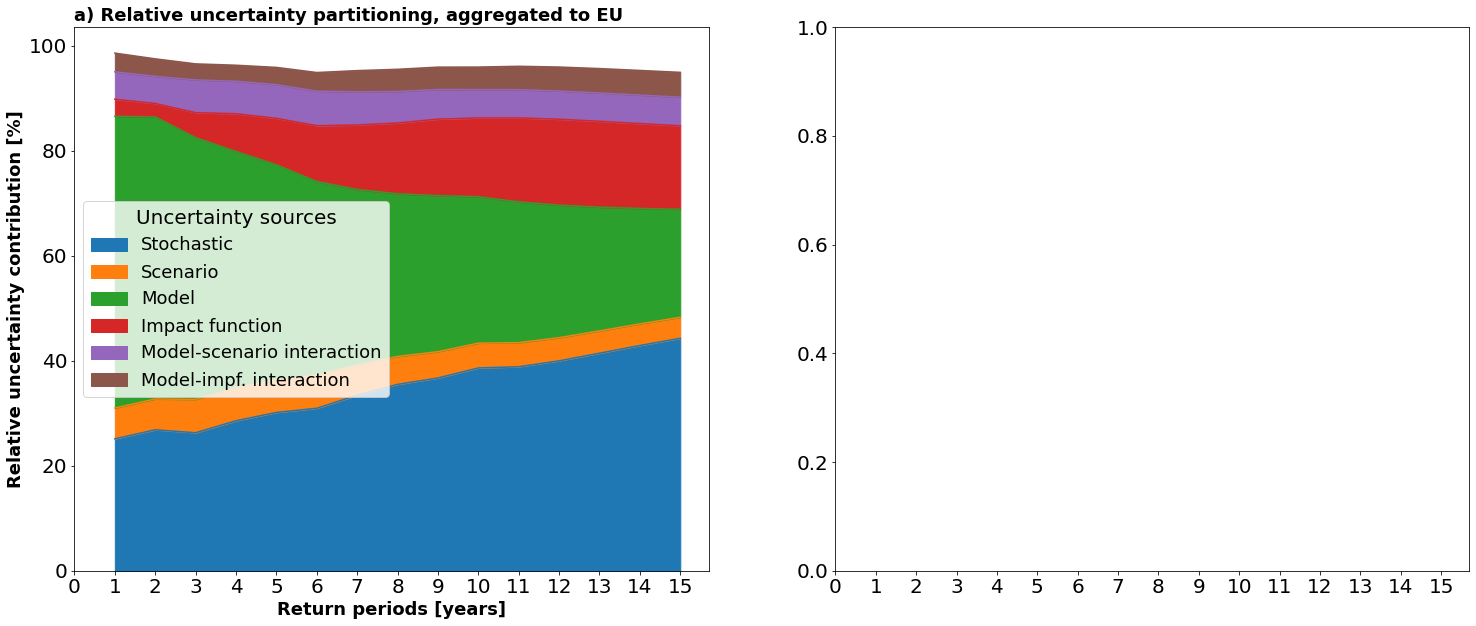

In [17]:
fig

In [99]:
unc_df_fut

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30
Uncertainty sources,,,,,,,,,,,,,,,,,
Stochastic,1.185655e+16,4.671367e+16,9.076543e+16,1.853763e+17,3.527581e+17,4.899635e+17,7.629034e+17,1.065600e+18,1.312643e+18,1.696161e+18,2.026806e+18,2.538173e+18,3.230263e+18,4.103076e+18,5.156610e+18,8.118468e+18,2.181156e+19
Scenario,1.645944e+15,5.740066e+15,1.121140e+16,2.469756e+16,4.128783e+16,6.015152e+16,7.332273e+16,8.537588e+16,9.589307e+16,1.072850e+17,1.188501e+17,1.319402e+17,1.465552e+17,1.626951e+17,1.803599e+17,2.971903e+17,6.468212e+17
Model,5.165045e+16,1.789289e+17,3.433272e+17,5.397260e+17,8.053376e+17,9.855287e+17,1.317250e+18,1.624138e+18,1.882851e+18,2.166965e+18,2.439464e+18,2.735992e+18,3.056551e+18,3.401140e+18,3.769758e+18,5.001234e+18,8.319832e+18
Impact function,1.290225e+15,2.656496e+15,1.359905e+16,4.034898e+16,8.999045e+16,1.546328e+17,2.593090e+17,3.746895e+17,4.926971e+17,6.270959e+17,7.992320e+17,9.932691e+17,1.209207e+18,1.447046e+18,1.706786e+18,3.356690e+18,8.333317e+18
Model-scenario interaction,3.791651e+15,1.111766e+16,3.107790e+16,5.951718e+16,1.024772e+17,1.516477e+17,1.959249e+17,2.396905e+17,2.788779e+17,3.400159e+17,4.013506e+17,4.907206e+17,6.081257e+17,7.535660e+17,9.270415e+17,1.722901e+18,4.724082e+18
Model-impf. interaction,2.837662e+15,8.633527e+15,1.542266e+16,2.800267e+16,5.217388e+16,7.675612e+16,1.368393e+17,1.938236e+17,2.333589e+17,2.834769e+17,3.561887e+17,4.474108e+17,5.571433e+17,6.853861e+17,8.321393e+17,1.261696e+18,2.723875e+18


## ANOVA Past

In [18]:
## ANOVA future
#unc_idx = ['Stochastic',"Scenario","Model","Impact function",'Model-scenario interaction','Model-imp. func. interaction']


normalized = True
ms_interaction = True
mi_interaction = True
unc_idx = ['Stochastic',"Scenario","Model","Impact function"]
if ms_interaction:
    unc_idx.append('Model-scenario interaction')
    
if mi_interaction:
    unc_idx.append('Model-impf. interaction')

unc_df_past = pd.DataFrame(columns=metrics,index=unc_idx)
for metric in metrics:
    df = res_df2[metric]["past"].copy()
    mod_mean = df.groupby(level="model").mean().mean(axis=1)
    impf_mean = df.groupby(level="impf").mean().mean(axis=1)
    scen_mean = df.mean()
    mod_scen_mean = df.groupby(level="model").mean()
    mod_impf_mean = df.groupby(level=["model","impf"]).mean().mean(axis=1)
    mod_scen_impf_mean = df.groupby(level=["model","impf"]).mean()
    nscen = len(scen_mean)
    nreal = nmems
    nmod = len(mod_mean)
    nimpf = len(impf_mean)
    ens_mean = df.mean().mean()
    #internal variabilty    
    intvar = 1/(nscen*nreal*nmod*nimpf)*np.sum(np.sum(np.sum((df.sub(mod_scen_impf_mean,axis=0))**2)))
    
    #scenario-inde model uncertainty
    mod_ind_var = 1/nmod*np.sum((mod_mean-ens_mean)**2)
    
    #scenario uncertainty
    scen_var = 1/nscen*np.sum((scen_mean-ens_mean)**2)
    
    #model-scenario interaction uncertainty
    modscen_int = 1/(nscen*nmod)*np.sum(np.sum((mod_scen_mean.add(ens_mean).sub(mod_mean,axis=0).sub(scen_mean,axis=1))**2))
    
    #impf uncertainty
    impf_ind_var = 1/nimpf*np.sum((impf_mean-ens_mean)**2)
    
    #model-impf interaction uncertainty
    modimpf_int = 1/(nmod*nimpf)*np.sum(np.sum((mod_impf_mean.add(ens_mean).sub(mod_mean,axis=0).sub(impf_mean,axis=0))**2))
    
    unc_df_past.loc['Stochastic',metric] = intvar
    unc_df_past.loc['Model',metric] = mod_ind_var
    unc_df_past.loc['Scenario',metric] = scen_var
    unc_df_past.loc["Impact function",metric] = impf_ind_var
    
    #tot uncertainty
    exp_unc = intvar + mod_ind_var + scen_var + impf_ind_var
    if ms_interaction:
        exp_unc = exp_unc + modscen_int 
        unc_df_past.loc['Model-scenario interaction',metric] = modscen_int
    if mi_interaction:
        exp_unc = exp_unc + modimpf_int
        unc_df_past.loc['Model-impf. interaction',metric] = modimpf_int
    
    # or tot uncertainty=
    tot_unc = np.sum(np.sum((df-ens_mean)**2))/(nscen*nreal*nmod*nimpf)
    print("Explained variance (%):"+format(100*exp_unc/tot_unc,'.4'))

    if normalized:
        unc_df_past[metric] = (100/exp_unc)*unc_df_past[metric]
    


Explained variance (%):100.0
Explained variance (%):100.0


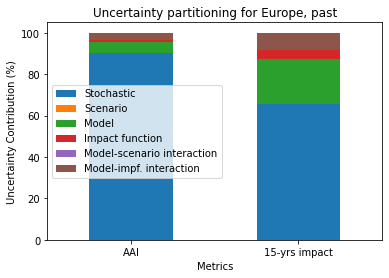

In [19]:
unc_df_past.columns = ['AAI',str(metrics[1])+'-yrs impact']
ax = unc_df_past.T.plot.bar(stacked=True,rot=0)
ax.set_ylabel('Uncertainty Contribution (%)')
ax.set_xlabel('Metrics')
ax.set_title('Uncertainty partitioning for Europe, past')
plt.legend(loc='center left')
#plt.savefig(savefigpath+'unc_part_EU.png',transparent=False)

In [20]:
def style_10high(v, props=''):
    return props if v > 10 else None
unc_df_past.index.name = 'Uncertainty partitioning for Europe, past (%)'
s2 = unc_df_past.style.applymap(style_10high, props='color:red;')
s2.format('{:.2f}')

,AAI,15-yrs impact
"Uncertainty partitioning for Europe, past (%)",,
Stochastic,90.26,65.35
Scenario,0.00,0.00
Model,5.06,21.99
Impact function,1.18,4.22
Model-scenario interaction,0.00,0.00
Model-impf. interaction,3.49,8.44
